In [ ]:
# !pip install transformers
# !pip install datasets
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.5 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import glob
from datetime import datetime

import torchvision
from torchvision.transforms import ToTensor

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, Input, LSTM, TimeDistributed, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa

import math

import matplotlib.pyplot as plt

In [ ]:
def load_images_from_folder(folder):
    print("Reading Images")
    df = pd.DataFrame()

    frame_index=0
    for filename in glob.glob(folder):
        #print(f'Filename : {filename}')

        idx_start=filename.find("heatstamps")
        assert (idx_start>-1), 'Directory names are not correct!'
        idx_end= filename.find("_")
        exp_id = filename[idx_start+11:idx_end]

        idx_start = idx_end+1
        idx_end = filename.find("_", idx_start)
        time = filename[idx_start:idx_end]

        idx_start = idx_end+1
        hrr = float(filename[idx_start:-4])

        df_row = pd.DataFrame(data=np.array([[exp_id, time, hrr, filename, frame_index]]), 
                              columns=['expID','time','hrr', 'file_path', 'frame_index'])
        df = pd.concat([df,df_row], ignore_index=True)
        frame_index += 1
                                       
    print("Finished Reading Images")
    # print("Total number of images read =", x_image.shape[0], end='\n      ')
    
    df = df.astype({"expID": int, "time": int, "hrr":float, 'file_path':str, 'frame_index': int}, errors='raise') 
    df["datetime"] = df.expID.apply(lambda x: datetime.fromtimestamp(int(x)))
    
    print("Creating df_exp pandaframe")
    df_exp = pd.DataFrame()
    expID_list = list(df.expID.unique())
    for exp in expID_list:
        df_temp = df[df.expID==exp].sort_values(by="time")
        time_list = df_temp.time.tolist()
        hrr_list = df_temp.hrr.tolist()
        filename_list = df_temp.file_path.tolist()
        frameindex_list = df_temp.frame_index.tolist()
        df_row = pd.DataFrame(data=np.array([[exp, time_list, hrr_list, filename_list, frameindex_list, len(df_temp)]]),
                              columns=['expID', 'time_list', 'hrr_list', 'filename_list', 'frameindex_list', 'num_of_frames'])
        df_exp = pd.concat([df_exp,df_row], ignore_index=True)
    df_exp = df_exp.astype({"expID": int,  'num_of_frames': int}, errors='raise') 
    return df, df_exp

In [ ]:
folder_name = '/content/drive/MyDrive/AI3 Project Group/DataFolder/full-heatstamps/*.jpg' # /content/drive/MyDrive/ai3/DataFolder/full-heatstamps small-heatstamps
size_x = 1080
size_y = 1920
df, df_exp =load_images_from_folder(folder_name)

df_test, df_test_exp = load_images_from_folder('/content/drive/MyDrive/AI3 Project Group/DataFolder/small-heatstamps/*.jpg')

Reading Images
Finished Reading Images
Creating df_exp pandaframe


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Reading Images
Finished Reading Images
Creating df_exp pandaframe


In [ ]:
train_df, val_df = train_test_split(df, train_size = 0.8)

In [ ]:
train_x = tf.ragged.constant( train_df.file_path.to_numpy() )
train_y = tf.ragged.constant( train_df.hrr.to_numpy() )

val_x = tf.ragged.constant( val_df.file_path.to_numpy() )
val_y = tf.ragged.constant( val_df.hrr.to_numpy() )

test_x = tf.ragged.constant( df_test.file_path.to_numpy() )
test_y = tf.ragged.constant( df_test.hrr.to_numpy() )

train_data  = tf.data.Dataset.from_tensor_slices( (train_x, train_y) )
validation_data = tf.data.Dataset.from_tensor_slices( (val_x, val_y) )
test_data = tf.data.Dataset.from_tensor_slices( (test_x, test_y) )

In [ ]:
@tf.function
def process_data(file_path, target_list):
  label = target_list
  img = tf.io.read_file(file_path) # load the raw data from the file as a string
  img = tf.image.decode_jpeg(img)
  img = tf.image.resize(img, [135, 240])
  img = img/255.
  
  return img, label

In [ ]:
train_data = train_data.map(process_data)
val_data = validation_data.map(process_data)
test_data = test_data.map(process_data)

tf.Tensor(355.12, shape=(), dtype=float64)


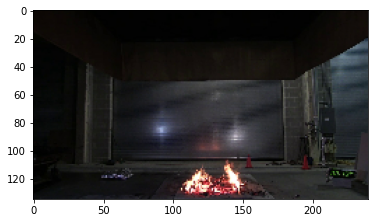

In [ ]:
for x,y in train_data.take(1):
  print(y)
  plt.imshow(x.numpy())

In [ ]:
train_data_batch = train_data.shuffle(5000)
train_data_batch = train_data_batch.batch(32)

val_data_batch = val_data.shuffle(5000)
val_data_batch = val_data_batch.batch(32)

test_data_batch = test_data.shuffle(5000)
test_data_batch = test_data_batch.batch(32)

In [ ]:
NUM_CLASSES = 1
INPUT_SHAPE = (135, 240, 3)
BATCH_SIZE = 32

# AUGMENTATION
IMAGE_SIZE = 36
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 100

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [256, 16]

In [ ]:
class ShiftedPatchTokenization(tf.keras.layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = tf.keras.layers.Reshape((num_patches, -1))
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [ ]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [ ]:
def create_vit_classifier(vanilla=False):
    inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(inputs)#(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = tf.keras.layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae'],
    )

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, mode="auto", restore_best_weights = True)

    history = model.fit(
        train_data_batch,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_data_batch,
        callbacks=[early_stopping_callback]
    )

    return model, history


# Run experiments with the vanilla ViT
vit = create_vit_classifier(vanilla=True)
model_, history = run_experiment(vit)

Epoch 1/100
128/128 [==============================] - 40s 89ms/step - loss: 5348351.0000 - mae: 1021.4988 - val_loss: 5684323.5000 - val_mae: 907.3088
Epoch 2/100
128/128 [==============================] - 29s 80ms/step - loss: 4081508.0000 - mae: 804.6520 - val_loss: 3763448.0000 - val_mae: 746.1560
Epoch 3/100
128/128 [==============================] - 30s 79ms/step - loss: 3298569.7500 - mae: 729.4103 - val_loss: 2889456.7500 - val_mae: 635.3110
Epoch 4/100
128/128 [==============================] - 29s 79ms/step - loss: 2819499.0000 - mae: 643.9365 - val_loss: 2421503.5000 - val_mae: 566.3384
Epoch 5/100
128/128 [==============================] - 29s 78ms/step - loss: 2594656.5000 - mae: 657.9714 - val_loss: 2657401.0000 - val_mae: 644.3707
Epoch 6/100
128/128 [==============================] - 29s 79ms/step - loss: 2299526.2500 - mae: 598.1789 - val_loss: 1944848.7500 - val_mae: 600.3947
Epoch 7/100
128/128 [==============================] - 29s 78ms/step - loss: 2052583.6250 - m

In [ ]:
model_.evaluate(test_data_batch)

10/10 [==============================] - 2s 22ms/step - loss: 6340630.0000 - mae: 1229.0593


[6340630.0, 1229.059326171875]

In [ ]:
model_.save("/content/drive/MyDrive/vision_transfomer_100_epochs")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/vision_transfomer_100_epochs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/vision_transfomer_100_epochs/assets


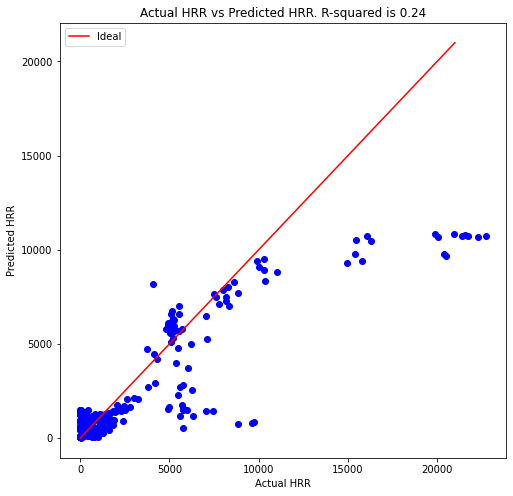

In [ ]:
pred = []
test = []
plt.figure(figsize=(8,8))
for x,y in test_data_batch.take(len(test_data_batch)):
  y_pred = model_.predict(x)
  y_test = y
  pred.append(y_pred.reshape(-1))
  test.append(y_test.numpy())
  plt.scatter(y_test,y_pred,c='blue')

pred_flatten = []
test_flatten = []

for x,y in zip(pred,test):
  pred_flatten.extend(x)
  test_flatten.extend(y)

r2 = r2_score(pred_flatten,test_flatten)

plt.plot(np.arange(21000),np.arange(21000),c='red',label='Ideal')
plt.title(f'Actual HRR vs Predicted HRR. R-squared is {round(r2,2)}')
plt.xlabel('Actual HRR')
plt.ylabel('Predicted HRR')
plt.legend()
plt.show()